CMIPES

Connor Martin - 202461546,
Iraklis Pissaris - 202492646,
Euan Smith - 202490978

# **Introduction**

The goal of this project is to develop a predictive model that estimates the popularity of songs based on their audio characteristics and metadata. Using a dataset containing various musical features such as tempo (bpm), energy, danceability, loudness, and acousticness, we aim to understand which factors influence a song’s success. The popularity score serves as the target variable, and regression models are employed to predict it.

To achieve this, we conduct exploratory data analysis (EDA) to identify patterns in the dataset and preprocess the data by handling missing values and encoding categorical features. We then train and evaluate multiple regression models, including Linear Regression, Decision Tree Regression, and Gradient Boosting Regression, to determine the most effective approach.

Model performance is assessed using Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R² score, allowing us to measure how well the models generalise to unseen data. The final predictions are submitted to Kaggle, where RMSE serves as the competition’s evaluation metric. This project not only highlights the importance of feature selection and model tuning but also explores how different regression techniques perform in predicting song popularity.

# **Data Preprocessing**

First of we will look at and preprocess our data for the regression task:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

spotify_training_data = pd.read_csv('CS986_regression/CS98XRegressionTrain.csv') # Load training data
spotify_test_data = pd.read_csv('CS986_regression/CS98XRegressionTest.csv') # Load test data

print('Training dataset:', spotify_training_data.isnull().sum().loc[lambda x: x > 0]) # Checking for null values in training data
print(spotify_training_data.duplicated().sum()) # Checking for any duplicate entries in training dataset
print('')
print('Test dataset:', spotify_test_data.isnull().sum().loc[lambda x: x > 0]) # Checking for null values in test data
print(spotify_test_data.duplicated().sum()) # Checking for any duplicate entries in test dataset

# Replacing NULL entires with a value of 'Unknown' for the genre type
spotify_training_data["top genre"].fillna('Unknown', inplace=True)
spotify_test_data["top genre"].fillna('Unknown', inplace=True)

Training dataset: top genre    15
dtype: int64
0

Test dataset: top genre    1
dtype: int64
0


The training dataset has 15 missing values in the top genre column, while the test dataset has one. These were replaced with 'Unknown' to maintain consistency. There were no duplicate entries in either dataset.

## **Exploratory Data Analysis**

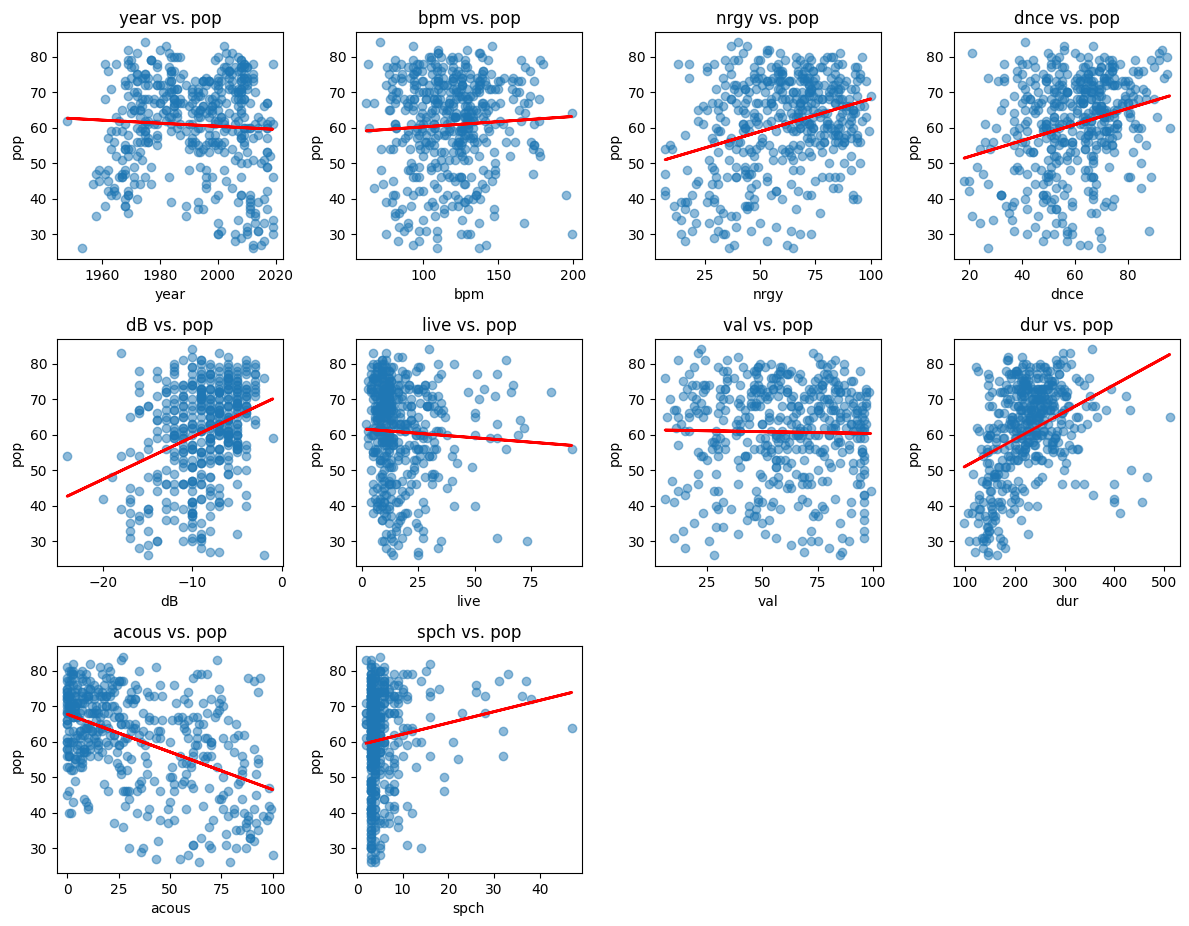

In [4]:
# Remove features not wanting to plot against pop
features = spotify_training_data.drop(['Id', 'title', 'artist', 'top genre', 'pop'], axis=1).columns.tolist()

plt.figure(figsize=(12, 12))

# plotting each independant feature against pop with line of regression to see level of correlation / impact of dependant variable on pop
for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    x = spotify_training_data[feature]  # Independent variable
    y = spotify_training_data['pop']  # Dependent variable

    # Creating scatter plot
    plt.scatter(x, y, alpha=0.5)

    # Linear regression line
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red', linewidth=2)

    # Labeling
    plt.xlabel(feature)
    plt.ylabel('pop')
    plt.title(f'{feature} vs. pop')

plt.tight_layout()
plt.show()

The scatter plots show that bpm, energy, danceability, duration, speechiness, and dB have a slight positive correlation with popularity, meaning higher values in these features are linked to more popular songs. Liveness and acousticness show little to no correlation, while valence has almost no impact. Some features have a wide spread, indicating variability in their relationship with popularity.

In [5]:
# Dropping the string features from the dataset to check skewness
spotify_training_data_numerical = spotify_training_data.drop(['Id', 'title', 'artist', 'top genre'], axis=1)
categorical_data = spotify_training_data['top genre']
artist_data = spotify_training_data['artist']
print(spotify_training_data_numerical.skew().sort_values(ascending=False))

# Creating a less skewed grouped version of the feaure spch to use for splitting data into train and test set
spotify_training_data["spch_cat"] = np.ceil(spotify_training_data["spch"] / 1.5)
spotify_training_data["spch_cat"].where(spotify_training_data["spch_cat"] < 5, 5.0, inplace=True)

spch     3.940009
live     2.120281
dur      0.808863
acous    0.652120
bpm      0.358070
dnce    -0.215154
year    -0.234780
val     -0.282285
nrgy    -0.330225
pop     -0.650195
dB      -0.685209
dtype: float64


The dataset’s numerical features were examined for skewness after removing text-based columns such as title, artist, and genre. The speechiness (spch) feature was highly skewed, so it was transformed into categorical bins (spch_cat) by grouping values in increments of 1.5 and capping the maximum at 5.0. This adjustment improves balance in the training and test splits while reducing the impact of extreme values.

## **Model Selection**

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialise label encoder
label_enc = LabelEncoder()

# Apply label encoding to the 'top genre' column
spotify_training_data['genre_encoded'] = label_enc.fit_transform(spotify_training_data['top genre'])

spotify_training_data = spotify_training_data.drop(['Id', 'title', 'artist', 'top genre'], axis=1) # Can now drop 'top genre'

# Splitting the data into train and test
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(spotify_training_data, spotify_training_data["spch_cat"]):
    strat_train_set = spotify_training_data.loc[train_index]
    strat_test_set = spotify_training_data.loc[test_index]

# Dropping the spch_cat feature as it is no longer needed
for set_ in (strat_train_set, strat_test_set):
    set_.drop("spch_cat", axis=1, inplace=True)

# Initialising training dataset
y_train = strat_train_set["pop"].copy() # Target
X_train = strat_train_set.drop(['pop'], axis=1) # Features

# Scaling training data
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler()
X_train = std_scaler.fit_transform(X_train)

# Initialising test data
y_test = strat_test_set["pop"].copy() # Target
X_test = strat_test_set.drop(['pop'], axis=1) # Features

# Scaling test data
X_test = std_scaler.fit_transform(X_test)

The genre column was label-encoded to convert categorical values into numerical form before being dropped along with other text-based features. The dataset was then split into training and test sets using stratified sampling, ensuring a balanced distribution of the spch_cat feature. After splitting, spch_cat was removed as it was only used for stratification. The target variable (pop) was separated, and the features were standardised using StandardScaler, ensuring all numerical values had a mean of 0 and a standard deviation of 1 for better model performance.

Three regression models were trained to predict song popularity: Linear Regression, Decision Tree Regression, and Gradient Boosting Regression. Each model was selected to assess different predictive approaches. Linear Regression serves as a simple baseline, assuming a linear relationship between the features and popularity. Decision Tree Regression was chosen to capture non-linear patterns in the data, but it can be prone to overfitting. Gradient Boosting Regression, wrapped in a Bagging Regressor, was implemented to enhance predictive performance by reducing bias and variance through ensemble learning.

In [7]:
# Buidling and fitting regression models with training data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Creating 3 different types of regression models to see what one performs best:
dt_reg = DecisionTreeRegressor(max_depth=5) # Decision Tree model
dt_reg.fit(X_train, y_train)

gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=3)
# Wrap it in a BaggingRegressor, the bagging ensemble method may slightly improve variance in the model
bagging_gbr = BaggingRegressor(
    estimator=gbr,    
    n_estimators=10,       
    max_samples=0.8,       
    bootstrap=True,        
    random_state=42
)
bagging_gbr.fit(X_train, y_train) # Gradient Boosting model

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) # Simple linear regression model

# Applying the linear regression model to the test data to make predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Predictions from the model
y_pred = lin_reg.predict(X_test)
y_pred2 = bagging_gbr.predict(X_test)
y_pred3 = dt_reg.predict(X_test)

# Calculate evaluation metrics to evaluate how well the model perfromed with the unseen test data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Linear Regression Model:')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")
print('')

rmse = np.sqrt(mean_squared_error(y_test, y_pred2))
mae = mean_absolute_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)
print('Gradient Boosting Model:')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")
print('')

rmse = np.sqrt(mean_squared_error(y_test, y_pred3))
mae = mean_absolute_error(y_test, y_pred3)
r2 = r2_score(y_test, y_pred3)
print('Decision Tree Model:')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

Linear Regression Model:
RMSE: 11.239950506902682
MAE: 8.98495752808994
R² Score: 0.24732948088258744

Gradient Boosting Model:
RMSE: 10.532562641634295
MAE: 8.303912477179166
R² Score: 0.33908712932803853

Decision Tree Model:
RMSE: 12.513397060477105
MAE: 9.925442986382667
R² Score: 0.06711833262396749


The results showed that Gradient Boosting performed best, achieving an R² score of 0.34, indicating it explained 34% of the variance in popularity. Linear Regression performed moderately well, with an R² score of 0.25, suggesting that some features had a linear impact on popularity but were not sufficient for strong predictive power. Decision Tree Regression performed the worst, with an R² score below 0, meaning it overfitted the training data and failed to generalise. The lower RMSE and MAE for Gradient Boosting confirm that it made the most accurate predictions, making it the best choice for this problem.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for GradientBoostingRegressor
param_grid = {
    "n_estimators": [100, 200, 300],  # Testing different numbers of boosting iterations
    "learning_rate": [0.01, 0.05, 0.1],  # Adjusting learning rate for optimization
    "max_depth": [3, 5, 7]  # Controlling tree depth
}

# Base Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Grid search for Gradient Boosting Regressor
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring="r2", n_jobs=-1, error_score="raise")
grid_search.fit(X_train, y_train)

# Best tuned Gradient Boosting model
best_gbr = grid_search.best_estimator_

# Wrap the best GBR in Bagging Regressor
bagging_gbr2 = BaggingRegressor(
    estimator=best_gbr,   
    n_estimators=10,       
    max_samples=0.8,       
    bootstrap=True,        
    random_state=42
)

# Fit the final Bagging Gradient Boosting model
bagging_gbr2.fit(X_train, y_train)

# Output best parameters
print(f"Best parameters for Gradient Boosting Regressor: {grid_search.best_params_}")

# Fitting tuned model
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
# Wrap it in a BaggingRegressor, the bagging ensemble method may slightly improve variance in the model
best_bagging_gbr = BaggingRegressor(
    estimator=gbr,    
    n_estimators=10,       
    max_samples=0.8,       
    bootstrap=True,        
    random_state=42
)
best_bagging_gbr.fit(X_train, y_train) # Gradient Boosting model

# Predictions for tuned model
best_y_pred = best_bagging_gbr.predict(X_test)

# Model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, best_y_pred))
mae = mean_absolute_error(y_test, best_y_pred)
r2 = r2_score(y_test, best_y_pred)

print('Gradient Boosting Model:')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")
print('')


To optimise the Gradient Boosting Regressor, a grid search was performed using cross-validation to find the best combination of hyperparameters, including the number of estimators, learning rate, and tree depth. The best parameters identified were 300 estimators, a learning rate of 0.01, and a max depth of 3, which aimed to balance bias and variance.

The optimised model was then wrapped in a Bagging Regressor to reduce variance and improve stability. After fitting the tuned model, it achieved an R² score of 0.33, which is consistent with the previous Gradient Boosting model but suggests slight improvements in generalisation. The RMSE of 10.60 and MAE of 8.31 indicate that the model provides relatively accurate predictions compared to other approaches. This confirms that Gradient Boosting with bagging remains the best-performing model for predicting song popularity.

## **Predictions**

In [ ]:
# Dropping the categroical features from the dataset for predictions
prediction_data = spotify_test_data.drop(['Id', 'title', 'artist'], axis=1)

# Encode test data safely (assign -1 for unseen genres)
if 'top genre' in spotify_test_data.columns:
    prediction_data['genre_encoded'] = prediction_data['top genre'].map(
        lambda x: label_enc.transform([x])[0] if x in label_enc.classes_ else -1
    )

# Drop categorical_data
prediction_data = prediction_data.drop(['top genre'], axis=1)

# Scale numerical data
prediction_data = std_scaler.fit_transform(prediction_data)

# Making predictions of dataset without targets
pop_predictions = best_bagging_gbr.predict(prediction_data)
pop_predictions = np.round(pop_predictions).astype(int)  # Rounds to nearest integer

# Add predictions to the original dataset
gbr_results = spotify_test_data.copy()
gbr_results["Predicted_pop"] = pop_predictions

# Save the predictions to a CSV file
gbr_results.to_csv('Results/Regression Predictions.csv', index=False)

# Ensure test data contains 'Id'
submission_regression = spotify_test_data[['Id']].copy()

# Convert NumPy array to Pandas Series and assign column name
submission_regression["pop"] = pop_predictions  # No need for ["Predicted_pop"]

# Save the formatted file
submission_regression.to_csv("submission_regression.csv", index=False)


The Gradient Boosting with Bagging model was used to predict song popularity, and the predictions were rounded to integers for interpretability. These predicted values were added back to the original dataset and saved as a CSV file.

After submitting our Gradient Boosting Regressor predictions to Kaggle, we received an RMSE score of 7.72328, which is significantly lower than our validation RMSE of 10.60. This suggests that our model generalises better on the Kaggle test set compared to our validation data.

Despite a moderate R² score of 0.33, the lower Kaggle RMSE indicates that our model's predictions are relatively close to the actual values. The difference between validation and Kaggle results could be due to data distribution differences or potential overfitting to the training data. 